## QUESTION
---
Conduct exploratory data analysis on the attached data and also implement Regression and Classification
models using the following guidelines
1. Conduct exploratory analysis of the data and provide a detailed description of the data
2. Implement regression modeling using 4 different regression algorithms to predict the age of employees
leaving the firm. Explain the results of each of the models and any variance observed
3. Implement classification modeling using 4 different classification algorithms models to predict the attrition
of employees leaving the firm. Explain the results of each of the models and any variance observed


## BINARY CLASSIFICATION
---
This is a binary classification problem that need me to build a predictive model to determine employee attrition.<br>
"Yes" is an employee is likely to leave the company and "No" otherwise.<br>

## DataWrangling and Exploratory Analysis
---
When conducting exploratory analysis there were no missing data nor duplicates and the initial shape of my dataset was (1470, 36) after wrangling it was (1470, 23).<br>
Following the wrangle function below you'll clearly see how some of the features were remove.<br>


In [116]:
#import libraries necessary for classification model `LogisticRegression`
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
from pandas import set_option
from sklearn.utils.validation import check_is_fitted

In [153]:
#creating a wrangle function
def wrangle(path):
    # load the data set to be used
    df =  pd.read_csv(path)
    
    #create new target column that is new attrition ("Emp_Attrition") column
    df["Emp_Attrition"] = [1 if  i == "Yes" else 0 for i in df["Attrition"]]
    
    # drop old target feature `Attrition`
    df.drop(columns="Attrition", inplace=True)
    
    # drop high/low cardinality features by low I mean only one unique record without a comparison
    df.drop(columns=["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], inplace= True)
    
    # List of Leaky features
    df_leaky_features = [i for i in df.columns if "Years" in i]
    
    # Drop leaky features
    df.drop(columns = df_leaky_features, inplace=True)
    
    #dropping multicollinear features
    df.drop(columns=["Age", "MonthlyIncome", "PercentSalaryHike"], inplace=True)
    
    return df

In [154]:
df = wrangle("./WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head(10)

,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Emp_Attrition
0,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,...,Single,19479,8,Yes,3,1,0,0,1,1
1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,...,Married,24907,1,No,4,4,1,3,3,0
2,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,...,Single,2396,6,Yes,3,2,0,3,3,1
3,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,...,Married,23159,1,Yes,3,3,0,3,3,0
4,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,...,Married,16632,9,No,3,4,1,3,3,0
5,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,79,3,...,Single,11864,0,No,3,3,0,2,2,0
6,Travel_Rarely,1324,Research & Development,3,3,Medical,3,Female,81,4,...,Married,9964,4,Yes,4,1,3,3,2,0
7,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,4,Male,67,3,...,Divorced,13335,1,No,4,2,1,2,3,0
8,Travel_Frequently,216,Research & Development,23,3,Life Sciences,4,Male,44,2,...,Single,8787,0,No,4,2,0,2,3,0
9,Travel_Rarely,1299,Research & Development,27,3,Medical,3,Male,94,3,...,Married,16577,6,No,3,2,2,3,2,0


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   BusinessTravel            1470 non-null   object
 1   DailyRate                 1470 non-null   int64 
 2   Department                1470 non-null   object
 3   DistanceFromHome          1470 non-null   int64 
 4   Education                 1470 non-null   int64 
 5   EducationField            1470 non-null   object
 6   EnvironmentSatisfaction   1470 non-null   int64 
 7   Gender                    1470 non-null   object
 8   HourlyRate                1470 non-null   int64 
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobRole                   1470 non-null   object
 12  JobSatisfaction           1470 non-null   int64 
 13  MaritalStatus             1470 non-null   object
 14  MonthlyRate             

In [121]:
#df["Emp_Attrition"] = [1 if  i == "Yes" else 0 for i in df["Attrition"]]


In [122]:
df.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Emp_Attrition'],
      dtype='object')

In [123]:
df["YearsWithCurrManager"].nunique()

18

In [132]:
for i in df.columns:
    if "Years" in i:
        print(i)

TotalWorkingYears
YearsAtCompany
YearsInCurrentRole
YearsSinceLastPromotion
YearsWithCurrManager


In [133]:
df_leaky_features = [i for i in df.columns if "Years" in i]
df_leaky_features

['TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

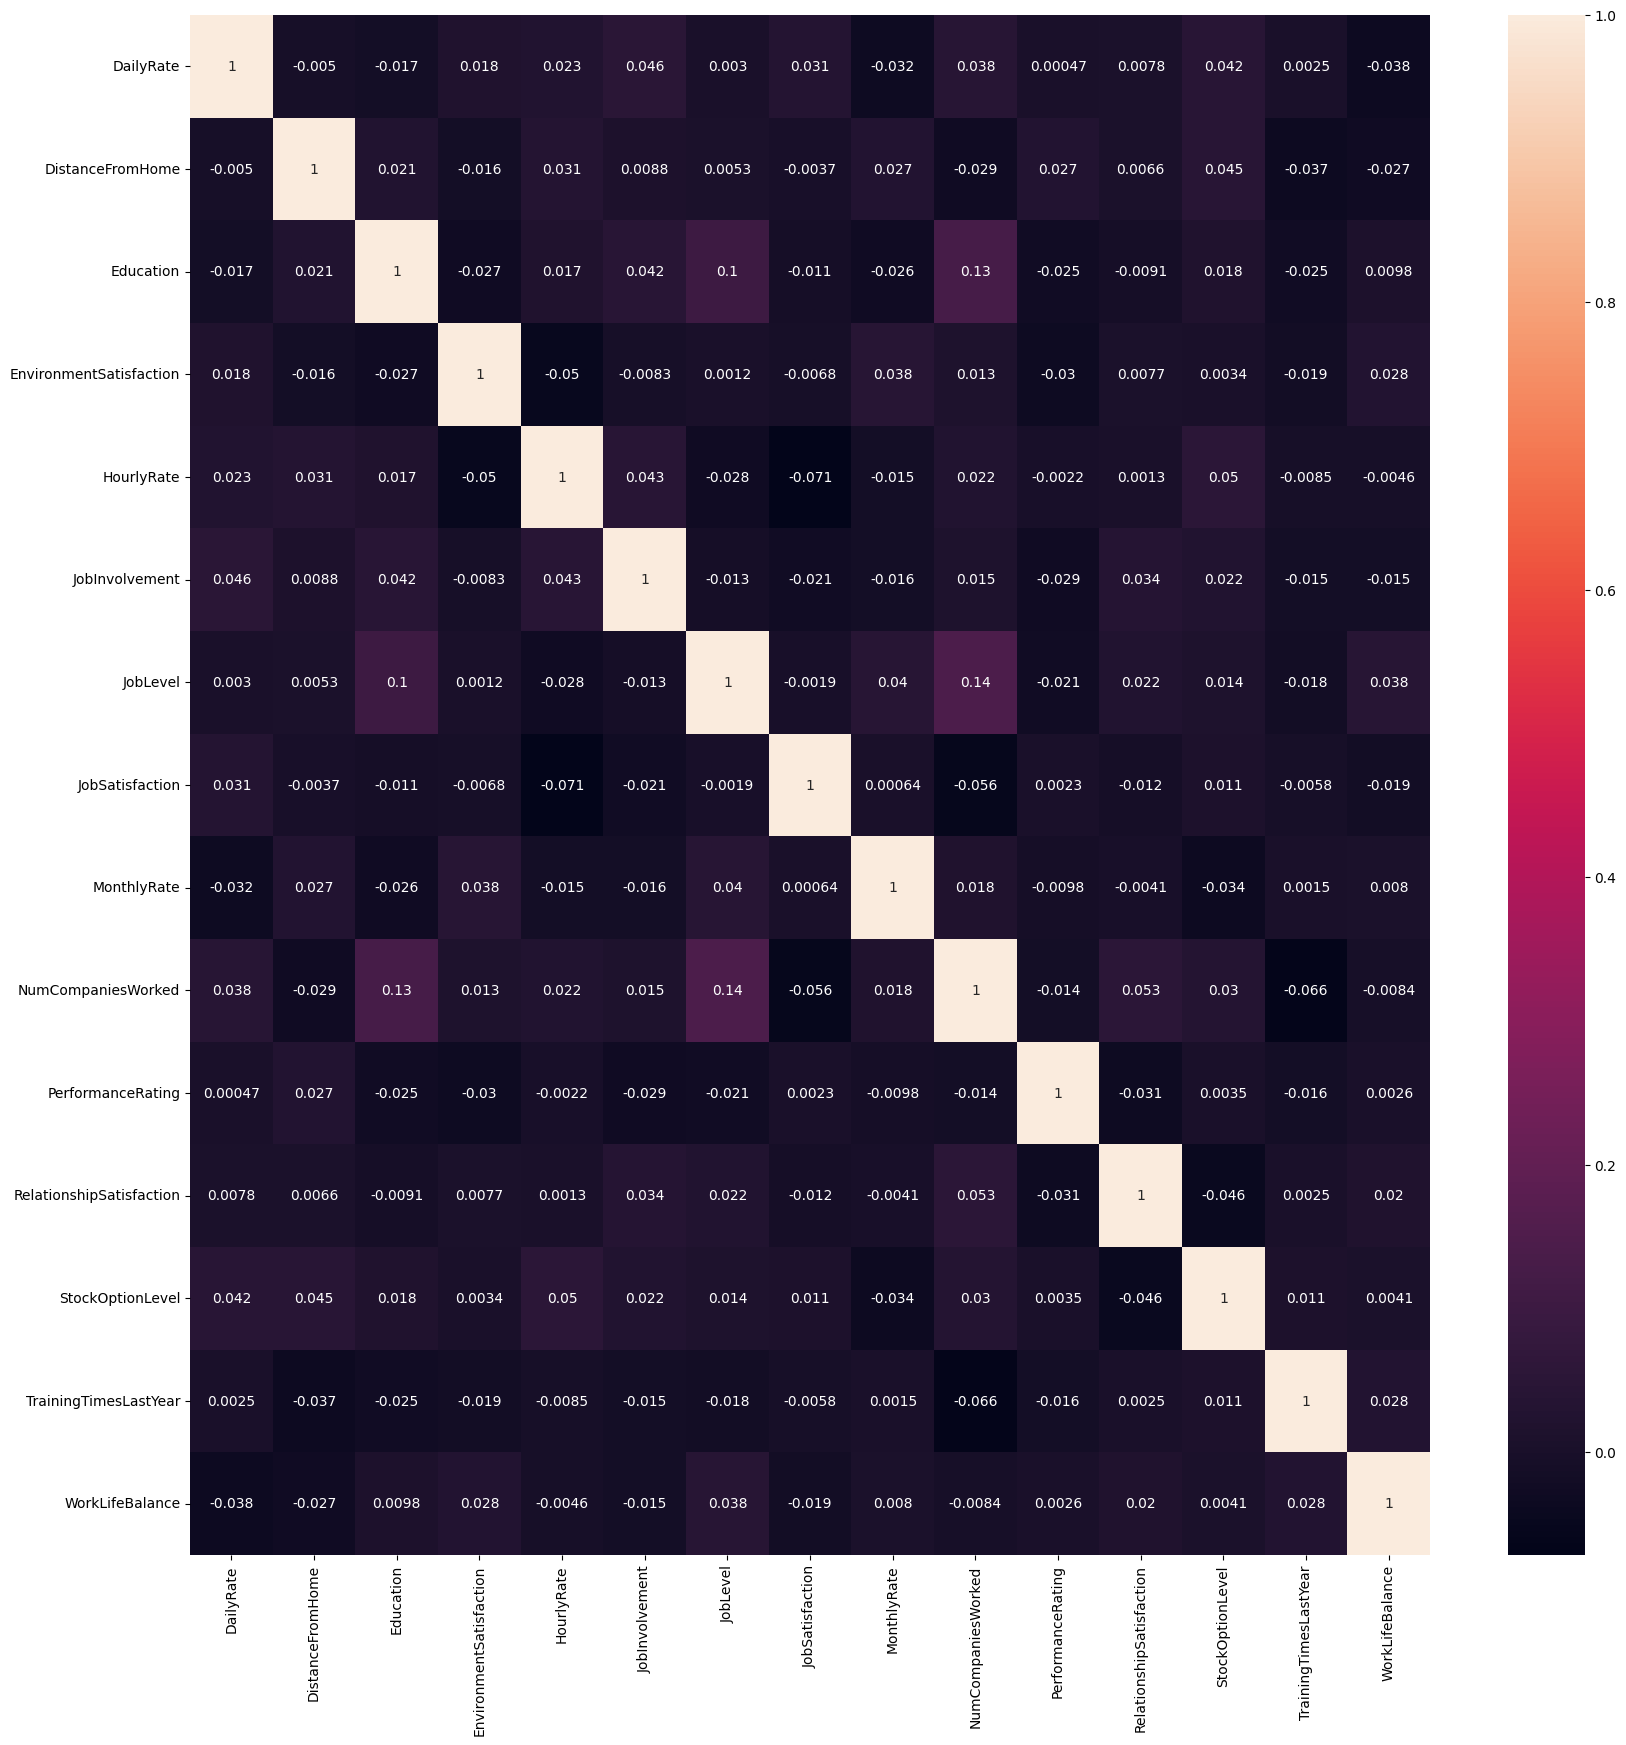

In [156]:
correlation = df.drop(columns="Emp_Attrition").select_dtypes("number")
# plot correlation heatmap
set_option('display.width', 100)
plt.figure(figsize = (20,20))
sns.heatmap(correlation.corr(), annot=True);

In [159]:
print(df.shape)
df.head()

(1470, 23)


,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Emp_Attrition
0,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,...,Single,19479,8,Yes,3,1,0,0,1,1
1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,...,Married,24907,1,No,4,4,1,3,3,0
2,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,...,Single,2396,6,Yes,3,2,0,3,3,1
3,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,...,Married,23159,1,Yes,3,3,0,3,3,0
4,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,...,Married,16632,9,No,3,4,1,3,3,0


## EXPLORATION

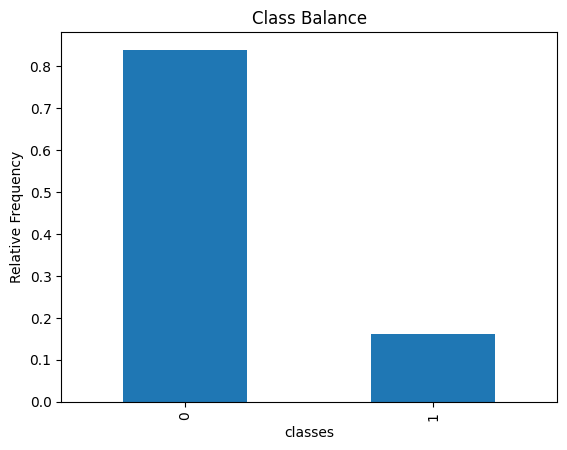

In [168]:
# Determining difference on my target feature by plotting a box plot
df["Emp_Attrition"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="classes",
    ylabel="Relative Frequency",
    title= "Class Balance"
);